In [1]:
## General Notes

In [2]:
#### All dependencies

## Data collection and visualisation

import yfinance as yf
import pandas as pd
from pandas import  read_csv
from pandas import set_option
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.dates as mpl_dates


import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')


## Prediction Engine, Featuring Engineering, Model Evaluation
import warnings
warnings.filterwarnings('ignore')
import os
# import pandas as pd
import numpy as np
import math
import datetime as dt
# import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Activation, Dense, Dropout
from keras.layers import LSTM

from itertools import cycle
# import plotly.offline as py
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots

# plt.style.use('seaborn-darkgrid')



In [3]:
#### Data Engineering


df = pd.DataFrame()

crypto_ticker = ['BTC', 'ETH', 'USDT']


#Extract data for each of the 10 coins from YahooFinance! using a For loop.
for each_crypto_ticker in crypto_ticker:

    each_crypto_ticker_index = crypto_ticker.index(each_crypto_ticker)
    crypto_data = yf.Ticker(f"{each_crypto_ticker}-USD").history(start='2015-01-01', end='2022-07-31', interval='1d')
    crypto_dataframe = pd.DataFrame(crypto_data)
    crypto_dataframe['crypto_ticker'] = each_crypto_ticker
    df = pd.concat([df, crypto_dataframe])


set_option('display.width', 500)
df = df.rename_axis('cryptodate').reset_index()

# ###Convert data to CSV and store it
df.to_csv("soligencecryptodata_withdate.csv")

###Extract data to different dataframes to simplify data understanding for each cryptocurrency
BTC = df.loc[df['crypto_ticker'] == 'BTC']
ETH = df.loc[df['crypto_ticker'] == 'ETH']
USDT = df.loc[df['crypto_ticker'] == 'USDT']


df

,cryptodate,Open,High,Low,Close,Volume,Dividends,Stock Splits,crypto_ticker
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550,0,0,BTC
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650,0,0,BTC
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400,0,0,BTC
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100,0,0,BTC
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800,0,0,BTC
...,...,...,...,...,...,...,...,...,...
6213,2022-07-26,1.000067,1.000128,0.999996,1.000047,48266723630,0,0,USDT
6214,2022-07-27,1.000048,1.000328,0.999980,1.000274,60104591185,0,0,USDT
6215,2022-07-28,1.000288,1.000360,1.000123,1.000200,75754591120,0,0,USDT
6216,2022-07-29,1.000205,1.000346,1.000169,1.000311,72013108986,0,0,USDT


In [4]:
# Obtain data for feature
close_price = BTC.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'crypto_ticker', 'cryptodate'])

# Split data into training and test data 80% for training data and 20% for test data
prediction_period = 554 # In days

training_data = close_price[:len(close_price)-prediction_period].values.reshape(-1,1)
testing_data = close_price[len(close_price)-prediction_period:].values.reshape(-1,1)

# Scale the data
scaler_train = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler_train.fit_transform(training_data)


scaler_test = MinMaxScaler(feature_range=(0,1))
scaled_test = scaler_test.fit_transform(testing_data)

In [5]:
scaled_test

array([[0.26879957],
       [0.27336682],
       [0.27495312],
       [0.27914386],
       [0.23512041],
       [0.29760448],
       [0.31511845],
       [0.31415318],
       [0.29035949],
       [0.29906852],
       [0.33971005],
       [0.38011858],
       [0.36887177],
       [0.39396471],
       [0.41706918],
       [0.40960108],
       [0.55982035],
       [0.56568329],
       [0.53349074],
       [0.59510142],
       [0.58677007],
       [0.57854468],
       [0.61174345],
       [0.59583731],
       [0.62168352],
       [0.68242886],
       [0.67276421],
       [0.75944611],
       [0.76380019],
       [0.7934696 ],
       [0.72482529],
       [0.61395022],
       [0.63209484],
       [0.57830443],
       [0.56277194],
       [0.55965533],
       [0.5380137 ],
       [0.63056876],
       [0.60477525],
       [0.64925084],
       [0.60852772],
       [0.61606929],
       [0.61576193],
       [0.66301934],
       [0.68443745],
       [0.73752987],
       [0.76192644],
       [0.798

In [6]:
#### Feature Engineering


#Create a series of timesteps and observations for X and Y axis for test and training data

def split_x_and_yaxis(dataset, look_back=3):

    dataX, dataY = [], []

    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = split_x_and_yaxis(scaled_train)
testX, testY = split_x_and_yaxis(scaled_test)



## View shape of the datasets
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

## Reshape data to 3D Tensors for LSTM for (Samples, timesteps, features) Batch size, timesteps or lookback, target features

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)


(2211, 3)
(2211,)
(551, 3)
(551,)
Shape of trainX:  (2211, 3, 1)
Shape of testX:  (551, 3, 1)


In [7]:
trainX

array([[[0.00335174],
        [0.00337102],
        [0.00253521]],

       [[0.00337102],
        [0.00253521],
        [0.00211947]],

       [[0.00253521],
        [0.00211947],
        [0.00237253]],

       ...,

       [[0.87675054],
        [0.89740064],
        [0.88360753]],

       [[0.89740064],
        [0.88360753],
        [0.87075521]],

       [[0.88360753],
        [0.87075521],
        [0.7545044 ]]])

In [8]:
#### LSTM Prediction Engine

##Create the LSTM Model

regressor = Sequential()
# First Layer
regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Second Layer
regressor.add(LSTM(units = 64, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Third Layer
regressor.add(LSTM(units = 64, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Fourth Layer
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))
regressor.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

In [9]:
## Compile the LSTM model

from  keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'new_crypto_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 150, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/150
65/70 [==========================>...] - ETA: 0s - loss: 0.0048
Epoch 1: val_loss improved from inf to 0.10514, saving model to new_crypto_model.hdf5
70/70 [==============================] - 7s 24ms/step - loss: 0.0107 - val_loss: 0.1051
Epoch 2/150
66/70 [===========================>..] - ETA: 0s - loss: 0.0259
Epoch 2: val_loss did not improve from 0.10514
70/70 [==============================] - 1s 11ms/step - loss: 0.0332 - val_loss: 0.1562
Epoch 3/150
66/70 [===========================>..] - ETA: 0s - loss: 0.0167
Epoch 3: val_loss improved from 0.10514 to 0.03610, saving model to new_crypto_model.hdf5
70/70 [==============================] - 1s 11ms/step - loss: 0.0189 - val_loss: 0.0361
Epoch 4/150
66/70 [===========================>..] - ETA: 0s - loss: 0.0283
Epoch 4: val_loss did not improve from 0.03610
70/70 [==============================] - 1s 10ms/step - loss: 0.0336 - val_loss: 0.0976
Epoch 5/150
66/70 [===========================>..] - ETA: 0s - loss: 0.011

In [10]:
## Save LSTM Model
#
from  keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

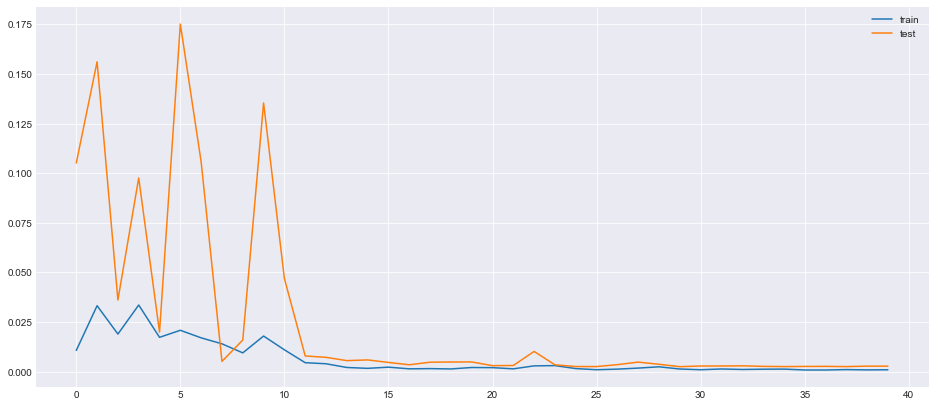

In [11]:
## Visualise Loss

plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
# Transformation to original form and making the predictions

predicted_btc_price_test_data = regressor.predict(testX)
# test_predicted = model_from_saved_checkpoint.predict(testing_data_X)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

18/18 [==============================] - 1s 4ms/step


In [13]:
test_actual

array([[32569.84960938],
       [30432.546875  ],
       [33466.09765625],
       [34316.38671875],
       [34269.5234375 ],
       [33114.359375  ],
       [33537.17578125],
       [35510.2890625 ],
       [37472.08984375],
       [36926.06640625],
       [38144.30859375],
       [39266.01171875],
       [38903.44140625],
       [46196.46484375],
       [46481.10546875],
       [44918.18359375],
       [47909.33203125],
       [47504.8515625 ],
       [47105.515625  ],
       [48717.2890625 ],
       [47945.05859375],
       [49199.87109375],
       [52149.0078125 ],
       [51679.796875  ],
       [55888.1328125 ],
       [56099.51953125],
       [57539.9453125 ],
       [54207.3203125 ],
       [48824.42578125],
       [49705.33203125],
       [47093.8515625 ],
       [46339.76171875],
       [46188.453125  ],
       [45137.76953125],
       [49631.2421875 ],
       [48378.98828125],
       [50538.2421875 ],
       [48561.16796875],
       [48927.3046875 ],
       [48912.3828125 ],


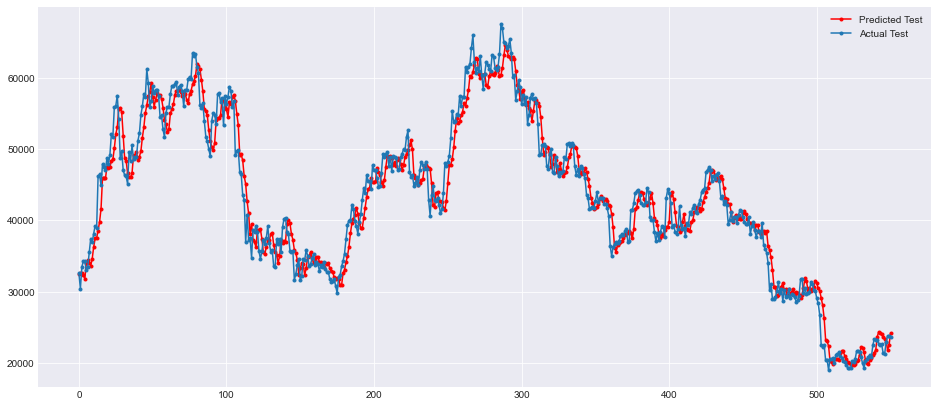

In [14]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [15]:
testX.shape

(551, 3, 1)

In [16]:
## Future 5 days

testX.shape
look_back = 90
past_days = testX[testX.shape[0] - look_back :]

past_days.shape
past_days

future_days = []
for i in range(89):
    forecast_test_x = model_from_saved_checkpoint.predict(past_days[i:i+1])
    forecast_test_x = scaler_test.inverse_transform(forecast_test_x.reshape(-1,1))
    future_days.append(forecast_test_x)

print ("Forecast:", np.array(future_days))



###Save this to trouble shoot scaled issues having Attribute Error
# future_days = []
# for i in range(5):
#     future_days = model_from_saved_checkpoint.predict(past_5days[i:i+1])
#     # forecast_test_x = scaled_ts.inverse_transform(forecast_test_x.reshape(-1,1))
#     future_days.append(future_days)
#
# print ("Forecast:", np.array(future_days))


1/1 [==============================] - 0s 21ms/step
Forecast: [[[38419.86 ]]

 [[38067.69 ]]

 [[38487.875]]

 [[38483.64 ]]

 [[38250.133]]

 [[38556.438]]

 [[36442.92 ]]

 [[35842.926]]

 [[34829.816]]

 [[33033.727]]

 [[30728.486]]

 [[30710.762]]

 [[29392.434]]

 [[29573.166]]

 [[29999.188]]

 [[30731.232]]

 [[31220.143]]

 [[30279.453]]

 [[30354.936]]

 [[29541.71 ]]

 [[30334.82 ]]

 [[29721.682]]

 [[29998.633]]

 [[30332.172]]

 [[29657.047]]

 [[29976.486]]

 [[29802.426]]

 [[29475.705]]

 [[29151.277]]

 [[29571.164]]

 [[30529.656]]

 [[31935.852]]

 [[31519.674]]

 [[30314.277]]

 [[30584.16 ]]

 [[30115.256]]

 [[30318.121]]

 [[30707.754]]

 [[31572.457]]

 [[31186.723]]

 [[30462.117]]

 [[30100.432]]

 [[29157.107]]

 [[28079.834]]

 [[26308.97 ]]

 [[23285.719]]

 [[23023.027]]

 [[22386.688]]

 [[20261.615]]

 [[20115.81 ]]

 [[19873.94 ]]

 [[20563.787]]

 [[20551.223]]

 [[20511.387]]

 [[20419.268]]

 [[21415.545]]

 [[21615.746]]

 [[21623.115]]

 [[20961.0

NameError: name 'scaled_td' is not defined

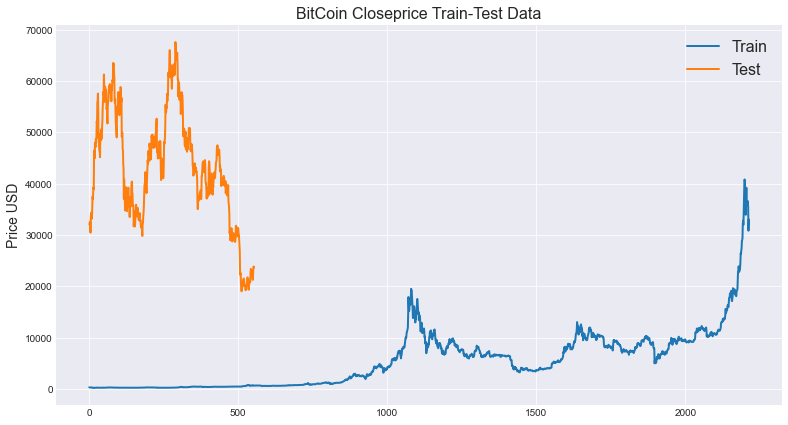

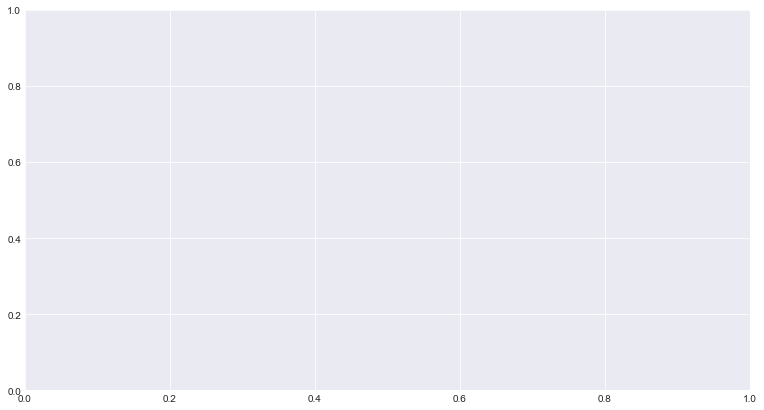

In [18]:


#### Data Visualisations


fig, ax = plt.subplots(1, figsize=(13, 7))

ax.plot(training_data, label='Train', linewidth=2)
ax.plot(testing_data, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('BitCoin Closeprice Train-Test Data', fontsize=16)
ax.legend(loc='best', fontsize=16)

# Scaled Data
fig, ax = plt.subplots(1, figsize=(13, 7))

ax.plot(scaled_td, label='Train', linewidth=2)
ax.plot(scaled_ts, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('BitCoin Closeprice Train-Test Data', fontsize=16)
ax.legend(loc='best', fontsize=16)